In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import json

import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
import random
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import trimesh
from datetime import datetime 


from torch.utils.data import random_split

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D



In [ ]:
def visualize_keypoints_3d(points, keypoints, title="Predicted Keypoints", figsize=(12, 8)):
    """
    Visualize point cloud with predicted keypoints
    
    Args:
        points: numpy array of shape (num_points, 3)
        keypoints: numpy array of shape (num_keypoints, 3)
        title: string
        figsize: tuple for figure size
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot point cloud
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
               c='lightblue', alpha=0.6, s=1, label='Point Cloud')
    
    # Plot keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], 
               c='red', s=100, label='Predicted Keypoints', marker='o')
    
    # Add keypoint numbers
    for i, kp in enumerate(keypoints):
        ax.text(kp[0], kp[1], kp[2], f'  {i}', fontsize=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    
    # Set equal aspect ratio
    max_range = np.array([points[:, 0].max()-points[:, 0].min(),
                         points[:, 1].max()-points[:, 1].min(),
                         points[:, 2].max()-points[:, 2].min()]).max() / 2.0
    mid_x = (points[:, 0].max()+points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max()+points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max()+points[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.view_init(elev=-90, azim=90)
    
    plt.show()



In [5]:
#predictor = KeypointPredictor("Old_Architecture/saved_models/kneenet++_4_5_final_2.pth")
#predictor = KeypointPredictor("New_Architecture/saved_models/2_points_epoch_50.pth")
def predict_points(model_path, input_ply, verbose = False, visualize = False, save = False, mesh = None):
    predictor = KeypointPredictor(model_path)

    mesh_path = input_ply 
    keypoints, points, metadata = predictor.predict_keypoints(mesh_path, mesh)

    if keypoints is not None:
        if verbose:
            print(f"Predicted {len(keypoints)} keypoints for {mesh_path}")
            print("Keypoints coordinates:")
        
        #for i, kp in enumerate(keypoints):
        #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")

        return keypoints[0], keypoints[1]

        
        # Visualize results
        if visualize:
            visualize_keypoints_3d(points, keypoints, f"Keypoints for {os.path.basename(mesh_path)}")        
        
        # Save keypoints to file
        if save:
            output_path = mesh_path.replace('.ply', '_keypoints.txt')
            save_keypoints_to_file(keypoints, output_path, mesh_path)
    else:
        print(f"Failed to process {mesh_path}")

    


In [6]:
predict_points("New_Architecture/saved_models/2_points_epoch_50.pth", "scans_2/12252.stl")

(TrackedArray([-0.15990216,  0.2763187 , -0.5003383 ], dtype=float32),
 TrackedArray([-0.2848039 ,  0.01031627, -0.48986724], dtype=float32))

(array([ 0.32605082, -0.20559107,  0.04805237], dtype=float32),
 array([0.32520336, 0.15791914, 0.03338365], dtype=float32))

In [31]:
predict_points("New_Architecture/saved_models/2_points_epoch_50.pth", "scans_3_aug/"+ scan_id + ".stl")

(TrackedArray([ 0.01415348, -0.2353699 ,  0.60722196], dtype=float32),
 TrackedArray([0.01315871, 0.19133246, 0.59000325], dtype=float32))

In [7]:
# Load STL mesh
scan_id = "12354"
#scan_id = "12408"

# Sample points on the mesh surface
pcd = mesh.sample_points_uniformly(number_of_points=60000)  # adjust as needed

labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=20, print_progress=True))

unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)

largest_cluster_label = unique_labels[np.argmax(counts)]

print("Cluster: " + str(largest_cluster_label))

indices = np.where(labels == largest_cluster_label)[0]


cleaned_pcd = pcd.select_by_index(indices)


kp1, kp2 = predict_points("New_Architecture/saved_models/2_points_epoch_50.pth", 
                          "scans_3_aug/"+ scan_id + ".stl", 
                          mesh = cleaned_pcd)

thigh_point = np.array(kp1)
shin_point = np.array(kp2)

mesh = o3d.io.read_triangle_mesh("scans_3/" + scan_id + ".stl")
mesh.compute_vertex_normals()


raw_points = np.asarray(cleaned_pcd.points)

# Create matplotlib 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
           c=raw_points[:, 2], cmap='viridis', s=0.5, alpha = 0.15)

ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)


ax.set_title('Point Cloud Preview')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ded = '''
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0, 1)
'''

plt.show()

NameError: name 'mesh' is not defined

In [8]:
# Load STL mesh
scan_id = "12354"
#scan_id = "12408"

# Sample points on the mesh surface
pcd = mesh.sample_points_uniformly(number_of_points=60000)  # adjust as needed

labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=20, print_progress=True))

unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)

largest_cluster_label = unique_labels[np.argmax(counts)]

print("Cluster: " + str(largest_cluster_label))

indices = np.where(labels == largest_cluster_label)[0]


cleaned_pcd = pcd.select_by_index(indices)


kp1, kp2 = predict_points("New_Architecture/saved_models/2_points_epoch_50.pth", "scans_3_aug/"+ scan_id + ".stl", mesh= None)

thigh_point = np.array(kp1)
shin_point = np.array(kp2)

mesh = o3d.io.read_triangle_mesh("scans_3/" + scan_id + ".stl")
mesh.compute_vertex_normals()


raw_points = np.asarray(cleaned_pcd.points)

# Create matplotlib 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
           c=raw_points[:, 2], cmap='viridis', s=0.5, alpha = 0.15)

ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)


ax.set_title('Point Cloud Preview')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ded = '''
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0, 1)
'''

plt.show()

NameError: name 'mesh' is not defined

In [9]:
def load_annotations(annotation_file):
    with open(annotation_file, "r") as f:
        annotations = json.load(f)
    
    model_id_to_keypoints = {}
    for entry in annotations:
        model_id = entry["model_id"]
        keypoints = entry["keypoints"]
        model_id_to_keypoints[model_id] = [kp["xyz"] for kp in keypoints]
    
    return model_id_to_keypoints


def get_keypoints_for_model(model_id, annotation_file):
    model_id_to_keypoints = load_annotations(annotation_file)
    
    if model_id in model_id_to_keypoints:
        return model_id_to_keypoints[model_id]
    else:
        print(f"Model ID {model_id} not found in annotations.")
        return None

In [10]:
def filter_mesh(scan_id, model_dir = "New_Architecture/saved_models/2_points_epoch_50.pth"):
    #mesh = o3d.io.read_triangle_mesh("scans_2/" + scan_id + ".stl")

    mesh = o3d.io.read_triangle_mesh("scans_3_aug/" + scan_id + ".stl")
    mesh.compute_vertex_normals()
    # Sample points on the mesh surface
    pcd = mesh.sample_points_uniformly(number_of_points=100000)  # adjust as needed

    raw_points = np.asarray(pcd.points)


    print("Scan ID: " + scan_id)

    kp1, kp2 = predict_points(model_dir, "scans_3_aug/"+ scan_id + ".stl")

    '''
    annotation_file = "knee_annotations/knees_4_5_aug_flipped.json"  # Path to your annotation file
    keypoints = get_keypoints_for_model(scan_id, annotation_file)
    if keypoints:
        #for i, kp in enumerate(keypoints):
        #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")
        thigh_point = np.array(keypoints[0])
        shin_point = np.array(keypoints[1])

    #print(thigh_point)

    '''

    thigh_point = np.array(kp1)
    shin_point = np.array(kp2)

    # Example: your model predicts these two points (numpy arrays)
    #thigh_point = np.array([-0.163, 0.358, -0.508])
    #shin_point  = np.array([-0.167, 0.030, -0.556])

    #-0.163 0.358 -0.508
    #-0.167 0.030 -0.556

    #-0.055 -0.140 0.478
    #-0.071 0.218 0.495

    # Compute leg axis vector
    axis_vec = shin_point - thigh_point
    axis_unit = axis_vec / np.linalg.norm(axis_vec)

    # Transform all points into axis coordinates
    points = np.asarray(pcd.points)

    vec_to_points = points - thigh_point  # vectors from thigh point to all points

    # Project vectors onto axis to get "height" along the axis
    heights = vec_to_points @ axis_unit  # dot product

    # Compute radial distance from axis line
    proj_points = np.outer(heights, axis_unit)  # projection vectors
    radial_vecs = vec_to_points - proj_points
    radii = np.linalg.norm(radial_vecs, axis=1)


    print(f"Max height: {np.max(heights):.2f}")
    print(f"Max radius: {np.max(radii):.2f}")

  
    # Jeet
    height_min = np.min(heights) + 0.1
    height_max = np.max(heights) - 0.15

    offset = min(0.4, np.max(radii) * 0.5)
    radius_max = np.max(radii) - offset
    radius_max = max(radius_max, 0)  # Don’t go negative



    # Create a mask for points inside cylinder
    mask = (
        (heights >= height_min) &
        (heights <= height_max) &
        (radii <= radius_max)
    )

    # Crop the point cloud
    cropped_points = points[mask]
    cropped_pcd = o3d.geometry.PointCloud()
    cropped_pcd.points = o3d.utility.Vector3dVector(cropped_points)

    print(f"axis_unit: {axis_unit}")
    print(f"heights: min={np.min(heights):.2f}, max={np.max(heights):.2f}")
    print(f"radii: min={np.min(radii):.2f}, max={np.max(radii):.2f}")
    print(f"height range: [{height_min}, {height_max}], radius_max: {radius_max}")
    print(f"Points before mask: {len(points)}, after mask: {np.sum(mask)}")


    '''
    # Create matplotlib 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
            c=points[:, 2], cmap='viridis', s=0.5)

    ax.set_title('Point Cloud Preview')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()
    '''



    points_cropped = np.asarray(cropped_pcd.points)
    '''
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()
    '''

    #print(f"Before crop: {len(points)} points")
    #print(f"After crop: {len(cropped_points)} points")

    # Optionally apply radius outlier removal to remove isolated noise
    # (You can also use DBSCAN or connected components)

    #cl, ind = cropped_pcd.remove_radius_outlier(nb_points=64, radius=0.05) # radius based filtering
    
    #cl, ind = cropped_pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 1.2) #statitical based filtered (not good)
    #cleaned_pcd = cropped_pcd.select_by_index(ind)



    labels = np.array(cropped_pcd.cluster_dbscan(eps=0.01, min_points=20, print_progress=True))

    unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)

    largest_cluster_label = unique_labels[np.argmax(counts)]

    indices = np.where(labels == largest_cluster_label)[0]

    cleaned_pcd = cropped_pcd.select_by_index(indices)

    print(f"After outlier removal: {len(cleaned_pcd.points)} points")




    fig = plt.figure(figsize=(10, 8))
   
   
   
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
            c=raw_points[:, 2], cmap='viridis', s=0.5, alpha = 0.05)
    
    ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
    ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5, alpha = 0.05)
    ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
    ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()


    cleaned_points = np.asarray(cleaned_pcd.points) # Only need this for radius filtering

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(cleaned_points[:, 0], cleaned_points[:, 1], cleaned_points[:, 2],
            c=cleaned_points[:, 2], cmap='cool', s=0.5, alpha = 0.05)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()

    return cleaned_pcd


In [ ]:
def filter_mesh(scan_id, model_dir = "New_Architecture/saved_models/2_points_epoch_50.pth"):
    #mesh = o3d.io.read_triangle_mesh("scans_2/" + scan_id + ".stl")

    mesh = o3d.io.read_triangle_mesh("scans_3_aug/" + scan_id + ".stl")
    mesh.compute_vertex_normals()
    # Sample points on the mesh surface
    pcd = mesh.sample_points_uniformly(number_of_points=100000)  # adjust as needed

    # Create a KD-tree for the sampled point cloud
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)



    raw_points = np.asarray(pcd.points)


    print("Scan ID: " + scan_id)

    kp1, kp2 = predict_points(model_dir, "scans_3_aug/"+ scan_id + ".stl")

    '''
    annotation_file = "knee_annotations/knees_4_5_aug_flipped.json"  # Path to your annotation file
    keypoints = get_keypoints_for_model(scan_id, annotation_file)
    if keypoints:
        #for i, kp in enumerate(keypoints):
        #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")
        thigh_point = np.array(keypoints[0])
        shin_point = np.array(keypoints[1])

    #print(thigh_point)

    '''

    thigh_point = np.array(kp1)
    shin_point = np.array(kp2)

    # Example: your model predicts these two points (numpy arrays)
    #thigh_point = np.array([-0.163, 0.358, -0.508])
    #shin_point  = np.array([-0.167, 0.030, -0.556])

    #-0.163 0.358 -0.508
    #-0.167 0.030 -0.556

    #-0.055 -0.140 0.478
    #-0.071 0.218 0.495

    # Compute leg axis vector
    axis_vec = shin_point - thigh_point
    axis_unit = axis_vec / np.linalg.norm(axis_vec)

    # Transform all points into axis coordinates
    points = np.asarray(pcd.points)

    vec_to_points = points - thigh_point  # vectors from thigh point to all points

    # Project vectors onto axis to get "height" along the axis
    heights = vec_to_points @ axis_unit  # dot product

    # Compute radial distance from axis line
    proj_points = np.outer(heights, axis_unit)  # projection vectors
    radial_vecs = vec_to_points - proj_points
    radii = np.linalg.norm(radial_vecs, axis=1)


    print(f"Max height: {np.max(heights):.2f}")
    print(f"Max radius: {np.max(radii):.2f}")

  
    # Jeet
    height_min = np.min(heights) + 0.1
    height_max = np.max(heights) - 0.15

    offset = min(0.4, np.max(radii) * 0.5)
    radius_max = np.max(radii) - offset
    radius_max = max(radius_max, 0)  # Don’t go negative



    # Create a mask for points inside cylinder
    mask = (
        (heights >= height_min) &
        (heights <= height_max) &
        (radii <= radius_max)
    )

    # Crop the point cloud
    cropped_points = points[mask]
    cropped_pcd = o3d.geometry.PointCloud()
    cropped_pcd.points = o3d.utility.Vector3dVector(cropped_points)

    print(f"axis_unit: {axis_unit}")
    print(f"heights: min={np.min(heights):.2f}, max={np.max(heights):.2f}")
    print(f"radii: min={np.min(radii):.2f}, max={np.max(radii):.2f}")
    print(f"height range: [{height_min}, {height_max}], radius_max: {radius_max}")
    print(f"Points before mask: {len(points)}, after mask: {np.sum(mask)}")


    '''
    # Create matplotlib 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
            c=points[:, 2], cmap='viridis', s=0.5)

    ax.set_title('Point Cloud Preview')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()
    '''



    points_cropped = np.asarray(cropped_pcd.points)
    '''
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()
    '''

    #print(f"Before crop: {len(points)} points")
    #print(f"After crop: {len(cropped_points)} points")

    # Optionally apply radius outlier removal to remove isolated noise
    # (You can also use DBSCAN or connected components)

    #cl, ind = cropped_pcd.remove_radius_outlier(nb_points=64, radius=0.05) # radius based filtering
    
    #cl, ind = cropped_pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 1.2) #statitical based filtered (not good)
    #cleaned_pcd = cropped_pcd.select_by_index(ind)



    labels = np.array(cropped_pcd.cluster_dbscan(eps=0.01, min_points=20, print_progress=True))

    unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)

    largest_cluster_label = unique_labels[np.argmax(counts)]

    indices = np.where(labels == largest_cluster_label)[0]

    cleaned_pcd = cropped_pcd.select_by_index(indices)

    print(f"After outlier removal: {len(cleaned_pcd.points)} points")




    fig = plt.figure(figsize=(10, 8))
   
   
   
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
            c=raw_points[:, 2], cmap='viridis', s=0.5, alpha = 0.05)
    
    ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
    ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5, alpha = 0.05)
    ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
    ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()


    cleaned_points = np.asarray(cleaned_pcd.points) # Only need this for radius filtering

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(cleaned_points[:, 0], cleaned_points[:, 1], cleaned_points[:, 2],
            c=cleaned_points[:, 2], cmap='cool', s=0.5, alpha = 0.05)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()

    return cleaned_pcd


Scan ID: 12116


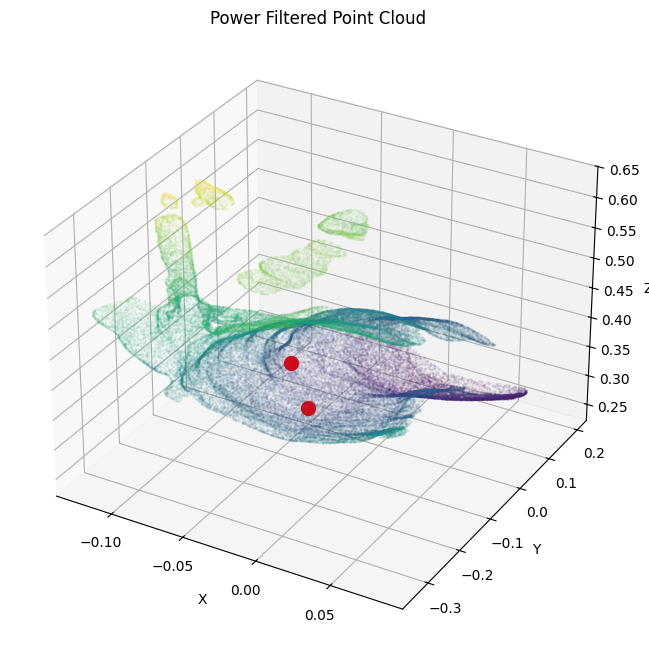

In [16]:
model_dir = "New_Architecture/saved_models/2_points_epoch_50.pth"
scan_id = "12116"

def project_point_to_surface(point, pcd, pcd_tree):
    """
    Project a single 3D point to its closest point on the sampled surface.
    """
    [_, idx, _] = pcd_tree.search_knn_vector_3d(point, 1)
    projected_point = np.asarray(pcd.points)[idx[0]]
    return projected_point


mesh = o3d.io.read_triangle_mesh("scans_3_aug/" + scan_id + ".stl")
mesh.compute_vertex_normals()
# Sample points on the mesh surface
pcd = mesh.sample_points_uniformly(number_of_points=100000)  # adjust as needed

# Create a KD-tree for the sampled point cloud
pcd_tree = o3d.geometry.KDTreeFlann(pcd)



raw_points = np.asarray(pcd.points)


print("Scan ID: " + scan_id)

kp1, kp2 = predict_points(model_dir, "scans_3_aug/"+ scan_id + ".stl")

'''
annotation_file = "knee_annotations/knees_4_5_aug_flipped.json"  # Path to your annotation file
keypoints = get_keypoints_for_model(scan_id, annotation_file)
if keypoints:
    #for i, kp in enumerate(keypoints):
    #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")
    thigh_point = np.array(keypoints[0])
    shin_point = np.array(keypoints[1])

#print(thigh_point)

'''

thigh_point = project_point_to_surface(np.array(kp1), pcd, pcd_tree)
shin_point = project_point_to_surface(np.array(kp2), pcd, pcd_tree)

fig = plt.figure(figsize=(10, 8))



ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
        c=raw_points[:, 2], cmap='viridis', s=0.5, alpha = 0.05)

ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

ax.set_title('Power Filtered Point Cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.set_xlim(-0.5, 0.5)
#ax.set_ylim(-0.5, 0.5)
#ax.set_zlim(0, 1)


plt.show()


Scan ID: 12354
Max height: 0.37
Max radius: 0.43
axis_unit: [-0.35839093  0.9182111  -0.16865459]
heights: min=-0.38, max=0.37
radii: min=0.00, max=0.43
height range: [-0.27980861891583453, 0.21923221192983636], radius_max: 0.21600804878533905
Points before mask: 100000, after mask: 65384
Precompute neighbors.[========================================] 100%
After outlier removal: 65367 points===============>] 97%


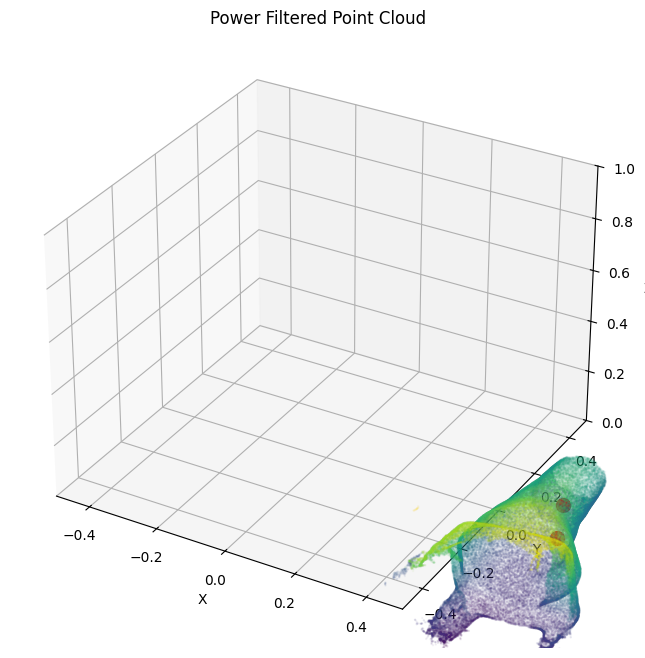

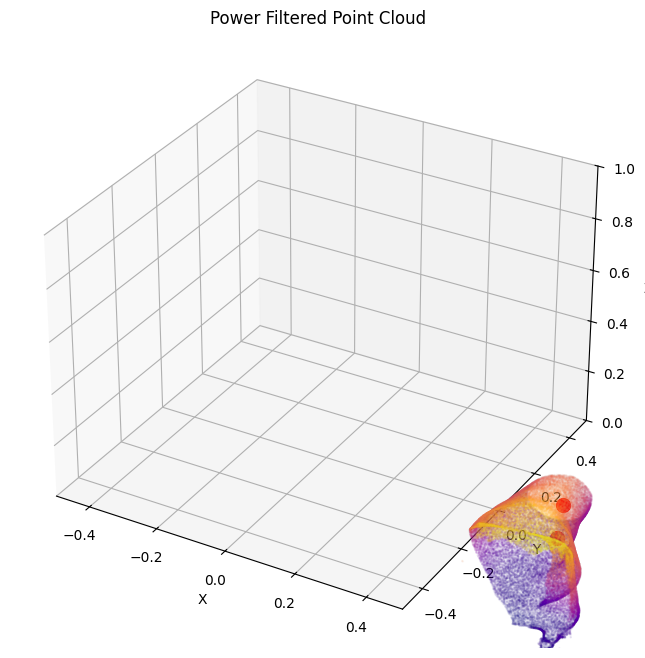

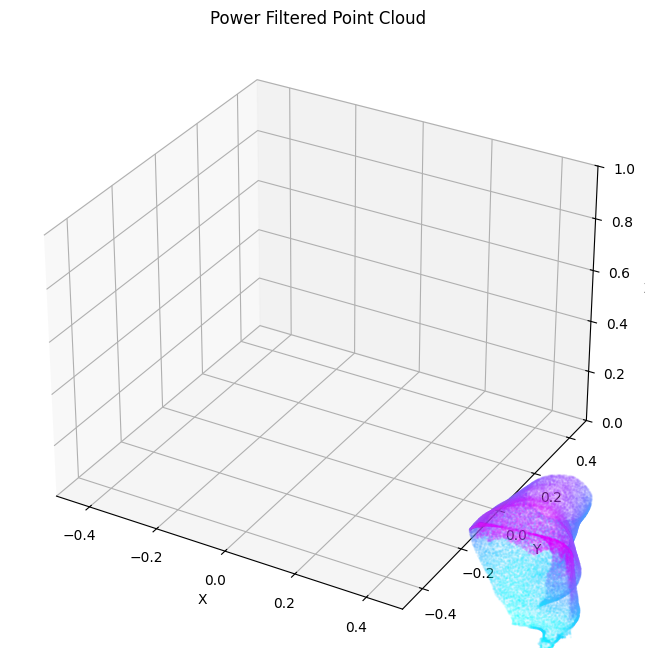

In [11]:
cleaned_pcd = filter_mesh("12354")

In [18]:
# Save to a PLY file
o3d.io.write_point_cloud("filtered_point_cloud.ply", cleaned_pcd)

True